# About

**Purpose**: Building code to trace MS2 spots from 3D confocal videos. We are isolating the MS2 spots first, then proceeding to isolating nuclei after. We have extended this to be a tutorial understanding how to look at MS2 data in preperation for presentation for the Eisen Lab Coding Club. If you are reading this and see errors, keep note and let us know about it as an issue on our Github repo: [here](https://github.com/DiscoveryDNA/reading_czi_stack_videos_GH/tree/master/notebooks)

**Overall the steps are as follows**
1. Part 1: Read in CZI files and associated metadata for analzying 
2. Part 2a: Isolate and label MS2 spots through time 
3. Part 2b: Isolate and label nuclei through time 
4. Part 3: Associate spots with nuclei 
5. Part 4: Creating the data structure to put all the information together


## Data

Ciera's faint spot data:

- Download `dmel_st14__i_63x-02.czi`: [https://drive.google.com/open?id=17RfXZ6Xea7M3uz-0CNkt46Bkk0BKyyG](https://drive.google.com/open?id=17RfXZ6Xea7M3uz-0CNkt46Bkk0BKyyGl).

-  All data: [https://drive.google.com/drive/folders/1gz0ZDjHVI20MsKUmDASuKc8mWiT32_rU](https://drive.google.com/drive/folders/1gz0ZDjHVI20MsKUmDASuKc8mWiT32_rU)


In [1]:
import numpy as np
import pandas as pd

import czifile
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
from ipywidgets import interact #for interations

#clustering
from sklearn.cluster import DBSCAN
from skimage import filters, measure, segmentation, feature, img_as_ubyte, morphology

from skimage.color import rgb2gray #to turn into grayscale

## MS2 spots
from skimage.feature import blob_doh, blob_dog, blob_log

##Nuclei
from skimage.feature import corner_harris, corner_foerstner, corner_peaks, corner_subpix

from scipy import ndimage as ndi

## Part 1: Read in CZI files and associated metadata for analzying

Read in CZI file and associated metadata. To save on space, we are just going to read in one video, with 5 time points.

In [61]:
# reading in images
# put path to where you put the file you downloaded
array1 = czifile.imread("/Users/cierapink/Desktop/dmel_st14__i_63x-02.czi")

array1 = array1.squeeze() #get rid of unwanted channels


# (time, channel, z-stack, y-axis, and x-axis), 0 is the spot's channel
array1.shape

(6, 2, 21, 928, 1389)

## Starting with one Stack

This is just a refresher to understand what kind of data we are working with. Isolate one time point. Turn into a maximum projection of that first stack and converts the truecolor image RGB to the grayscale image. We display the image so that you can see how faint our MS2 spots are.

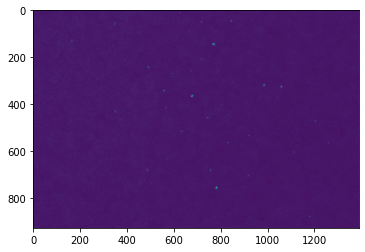

In [3]:
zstack = array1[1, 0, :, ...] #MS2 (spots) #FIRST TIMEPOINT
IM_MAX = np.max(zstack, axis=0) #maximum projection 
image_gray = rgb2gray(IM_MAX) # turn to grey scale

#original z-stack image: 
plt.imshow(IM_MAX);

# Part 2a: Isolate and label MS2 spots through time 

We'll begin by taking a look at the MS2 spots and figuring out a way to cluster each spot into its own group throughout timepoints. This is so we can trace the on/off behavior of each MS2 spot.

## blob detection 

Essentially we are using two blob detection algorithms that uses the circular nature of our MS2 spots for segmentation. Notice that the first image/dataframe set uses the `blob_doh()` algorithm and the second image/dataframe set uses the `blob_dog()` algorithm. More information about these algorithms can be found [here](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html). Below we will compare these two algorithms.


Note: Since the spots are so faint, we use the two functions below are used to conveniently show how the spots are detected and to gather the coordinates of each spot into a dataframe by timepoints.

In [4]:
# function to display image and create dataframe: 

def show_blobs(blobs_coords): 
    
    fig, ax = plt.subplots() #created ax just to add patches
    plt.imshow(IM_MAX)

    for idx in range(len(blobs_coords)):
        for blob in blobs_coords: 
            y, x, r = blob
            c = plt.Circle((x, y), r, color="lime", linewidth=2, fill=False)
            ax.add_patch(c)


    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint_1 = pd.DataFrame({"spots": np.arange(1, len(blobs_coords)+1), "x":x, "y":y, "sd":sd})
    
    return timepoint_1

In [5]:
def timepoint_df(blobs_coords, tp): 
    #make into dataframe first (no cleaning)
    x = [arr[1] for arr in blobs_coords] #note, the x and y coordinates are returned in opposite order hence the indexing
    y = [arr[0] for arr in blobs_coords]
    sd = [arr[2] for arr in blobs_coords]
    timepoint = pd.DataFrame({"spots": np.arange(1, len(blobs_coords)+1), 
                              "x":x, 
                              "y":y, 
                              "sd":sd, 
                              "timept": np.zeros(len(blobs_coords)) + tp})
    
    return timepoint

In [6]:
# running blob_doh
blobs_doh_spots = blob_doh(image_gray, max_sigma=30, threshold=.005) 

/Users/cierapink/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/Users/cierapink/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/Users/cierapink/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/Users/cierapink/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


,spots,x,y,sd
0,1,781.0,755.0,4.222222
1,2,1386.0,531.0,1.000000
2,3,677.0,365.0,4.222222
3,4,571.0,351.0,1.000000
4,5,557.0,342.0,4.222222
5,6,1057.0,325.0,4.222222
6,7,858.0,307.0,1.000000
7,8,768.0,143.0,7.444444
8,9,740.0,43.0,1.000000


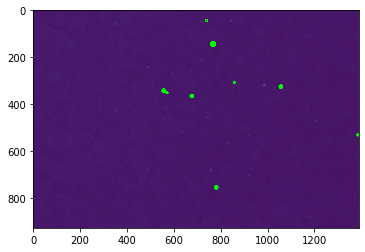

In [7]:
# Using the above function to see what the blob finding algorithms are doing
show_blobs(blobs_doh_spots)

,spots,x,y,sd
0,1,1180.0,879.0,2.560
1,2,781.0,756.0,4.096
2,3,487.0,681.0,4.096
3,4,756.0,680.0,2.560
4,5,1111.0,604.0,2.560
5,6,831.0,564.0,2.560
6,7,634.0,515.0,2.560
7,8,1203.0,472.0,2.560
8,9,744.0,458.0,2.560
9,10,350.0,431.0,4.096


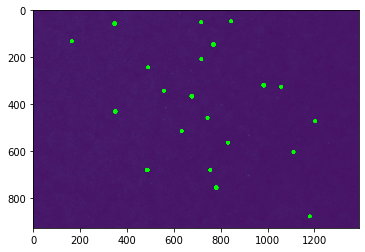

In [8]:
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.08) 
show_blobs(blobs_dog)

### blob detection conclusions

There are a couple of blob detection methods that can be used (blob_doh, blob_dog, blob_log) and each one has its own advantages and disadvantages. But after comparing some of the outputs, I decided that the blob_dog algorithm works best with our current set of images. 

- The blob-doh algorithm seems to miss out on some of the more faint spots and supposedly has a harder time detecting small spots/blobs (< 3 pixels) accurately according to the documentation. As for the blob-log alogrithm, it takes too long and doesn't seem to have too much more of an advantage than the blob-dog one. 

- A lower threshold for the blob-dog algorithm captures the faint spots which we may not be able to see with our eyes (because it's some small). We can adjust for the threshold value later on (and figure out a way to automate this process).

Some references to read: https://en.wikipedia.org/wiki/Blob_detection#The_determinant_of_the_Hessian (blob detection algorithm)

## Blob detection and timepoint assignments

Above we showcased how the blob detection algorithm works for the maximum projection image of one timepoint. 

Now, we will implement the same blob detection algorithm for all timepoints and aggregate the coordinates of all MS2 spots into one dataframe. The reason for this is 1. we would like to give a unique ID to each MS2 spot through time based on position and 2. It will allow us to test our algorthim detection. If we see if multiple MS2 spots exist in the same space over time.

In [9]:
def all_timepoints_combined(total_tp, array):
    
    df = pd.DataFrame() #initalize
    
    for i in range(total_tp): 
        zstack = array[i, 0, :, ...] #MS2 (spots) 
        IM_MAX = np.max(zstack, axis=0) #maximum projection 
        image_gray = rgb2gray(IM_MAX)
        
        blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.08)
        timepoint = timepoint_df(blobs_dog, i)
        df = df.append(timepoint).reset_index(drop=True)
    
    return df

In [10]:
array1_timepoints = all_timepoints_combined(6, array1)

/Users/cierapink/opt/miniconda3/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


In [11]:
array1_timepoints.head()

,spots,x,y,sd,timept
0,1,393.0,927.0,16.777216,0.0
1,2,1180.0,874.0,2.560000,0.0
2,3,918.0,705.0,2.560000,0.0
3,4,486.0,670.0,2.560000,0.0
4,5,738.0,568.0,2.560000,0.0


As a sanity check, below is a visual movie/slideshow representation of the spots that were isolated via the algorithm above: 

In [12]:
temp = array1_timepoints[["x", "y", "timept"]].groupby("timept").agg(list)
temp

,x,y
timept,,
0.0,"[393.0, 1180.0, 918.0, 486.0, 738.0, 659.0, 11...","[927.0, 874.0, 705.0, 670.0, 568.0, 560.0, 552..."
1.0,"[1180.0, 781.0, 487.0, 756.0, 1111.0, 831.0, 6...","[879.0, 756.0, 681.0, 680.0, 604.0, 564.0, 515..."
2.0,"[171.0, 788.0, 577.0, 926.0, 431.0, 494.0, 764...","[839.0, 770.0, 769.0, 718.0, 701.0, 691.0, 687..."
3.0,"[781.0, 926.0, 429.0, 770.0, 636.0, 746.0, 558...","[769.0, 719.0, 697.0, 696.0, 511.0, 451.0, 410..."
4.0,"[172.0, 779.0, 431.0, 777.0, 1129.0, 745.0, 10...","[836.0, 772.0, 704.0, 691.0, 619.0, 580.0, 556..."
5.0,"[1189.0, 1042.0, 856.0, 762.0, 680.0, 610.0, 5...","[927.0, 927.0, 927.0, 927.0, 927.0, 927.0, 927..."


In [13]:
@interact(index=(0, 5))
def scatter(index=0): 
    x = temp.iloc[index,:]["x"]
    y = temp.iloc[index,:]["y"]
    plt.scatter(x, y)
    
    #formatting:
    plt.xlim([0, 1400])
    plt.xticks(np.arange(0, 1400, 200))
    plt.ylim([1000, 0])
    plt.yticks(np.arange(0, 1000, 200))

interactive(children=(IntSlider(value=0, description='index', max=5), Output()), _dom_classes=('widget-interac…

In [14]:
@interact(i=(0,5))
def show_images(i=5):
    zstack = array1[i, 0, :, ...] #MS2 (spots)
    IM_MAX = np.max(zstack, axis=0) #maximum projection 
    plt.imshow(IM_MAX)

interactive(children=(IntSlider(value=5, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

# Clustering

So at this point, we have a basic understanding of where MS2 spots are, but we still now there are two points we want to address

1. Regardless of nuclei, can we assign a unique identifier to each spot? How do we track one spot? 
2. What about noise? Can we reduce false positives?

Now that we have the coodinates for the MS2 spots, we will want to cluster them into separate groups. Remember, we ignore the last timepoint -- in this case it's timepoint 5. 

In [15]:
# Should prob remove right in the begining
trial1 = array1_timepoints[array1_timepoints["timept"] != 5][["x", "y", "timept"]]  
trial1.head()

,x,y,timept
0,393.0,927.0,0.0
1,1180.0,874.0,0.0
2,918.0,705.0,0.0
3,486.0,670.0,0.0
4,738.0,568.0,0.0


Here we are specifying the DBSCAN clustering algorithm to determine how to cluster the MS2 spots. More information about the DBSCAN clustering algorithm can be found [here](https://en.wikipedia.org/wiki/DBSCAN). But essentially, the density based spacial clustering algorithm (DBSCAN) groups together points that are closely packed together, and outliers are points that lie alone and thus have low-density. 

This clustering algorithm will help us identify whether the MS2 spots are unique through out timepoints and if they are actually MS2 spots (or if they're noise). Because we are clustering all the MS2 spots from all timepoints, under the assumption that each spot remains in similar areas throughout time. We can group all these "blob/points" and see where groups form. Each formed group is essentially one unique MS2 spot. 

In [16]:
cluster = DBSCAN(eps=40, min_samples=2) #can specify min distance to be considered neighbors,  min # of samples in neighborhood 
lab = cluster.fit_predict(trial1) #fits clustering algorithm and returns a cluster label

lab

array([-1,  0,  1,  2,  3, -1, -1, -1,  4,  5,  6,  7, -1,  8,  9, 10, 11,
       12, 13, 14,  0, 15,  2, 16, 17, -1, 18, -1, 19, 20,  4,  5,  6,  7,
        8, 10, 12, 11, 13, -1, 14, 21, 15, -1,  1, 22,  2, 16, -1, -1, 18,
       19, 20, 23, 24,  4,  5,  6,  7, -1, 12, 11, 13, 14, 15,  1, 22, 16,
       18, 19, 23, 24,  4,  5,  6,  7,  9, 10, 25, 12, 13, 14, 26, 21, 15,
       22, 16, 17,  3, -1, 18, -1, 20, 23, -1, 24,  4,  5,  9, 10, 25, -1,
       12, 11, 13, 26])

Notice that the algorithm labels each spot. Spots with the same label are from the same group. Spots labeled as -1 are considered outliers.

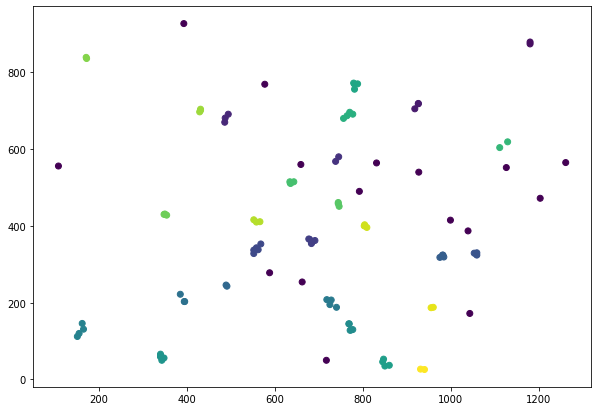

In [17]:
## Plot and color the groups.  Its a little hard to identify 24 unique colors though.
plt.figure(figsize=(10, 7))  
plt.scatter(trial1["x"], trial1["y"], c=cluster.labels_);

We can add these MS2 labels to the dataframe, and groupby later to ensure that each group does not have MS2 spots from the same timepoint.

Remember, each group should not have points from the same timepoint, because we are grouping all MS2 from all timepoints to validate whether the MS2 coordinates we found earlier are actually MS2 spot coordinates and not random noise.

- If the coordinates are actually identifying a MS2 spot, then there should be multiple coodinates clustered around the same area for all timepoints.

- If there is a lone coordinate cluster, then this indicates that it could be random noise, this will be more powerful when we combine with more time points.
- **Question**: do we know if there is a minimum time an MS2 spot is on?

In [18]:
trial1["DBSCAN_labels"] = lab
trial1.head()

,x,y,timept,DBSCAN_labels
0,393.0,927.0,0.0,-1
1,1180.0,874.0,0.0,0
2,918.0,705.0,0.0,1
3,486.0,670.0,0.0,2
4,738.0,568.0,0.0,3


In [19]:
# can check (notice that none of the aggregated points are from the same timepoint--
# so no overlaps, which is more evidence that these groups are not noise)
trial1[["DBSCAN_labels", "timept"]].groupby("DBSCAN_labels").agg(list)

,timept
DBSCAN_labels,
-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, ..."
0,"[0.0, 1.0]"
1,"[0.0, 2.0, 3.0]"
2,"[0.0, 1.0, 2.0]"
3,"[0.0, 4.0]"
4,"[0.0, 1.0, 2.0, 3.0, 4.0]"
5,"[0.0, 1.0, 2.0, 3.0, 4.0]"
6,"[0.0, 1.0, 2.0, 3.0]"
7,"[0.0, 1.0, 2.0, 3.0]"


# Part 2b: Isolate and label nuclei through time 

Now that we have the candidate MS2 spot coordates and have identified groupings for each of these spots, we can move on to segmenting the nuclei. 

So what do we need from the Nuclei Information?

1. We use nuclei to assign MS2 spot coordinates to specific nuclei.  
    -  for this we need perimeter or area coordinates of nuclei
    
2. We need unique identifers for each nuclei. We need to be able to track nuclei in space and time. 
    - For this, we likely need to track centers of nuclei and cluster
    - Tracking spots algorithm might be useful


---

## Some Image Analysis Concepts that are imporant (interlude)

In image analysis, there is always this push and pull of making the image less "sharp" to remove noise. It may seem counter intuitive that you make the image shittier looking to find what you want, but its all about reducing noise.


- **Blurring**: When we blur an image, we make the color transition from one side of an edge in the image to another smooth rather than sudden. The effect is to average out rapid changes in pixel intensity. The blur, or smoothing, of an image removes “outlier” pixels that may be noise in the image. Blurring is an example of applying a low-pass filter to an image. In computer vision, the term “low-pass filter” applies to removing noise from an image while leaving the majority of the image intact. A blur is a very common operation we need to perform before other tasks such as edge detection.
- **Thresholding**: is a type of image segmentation, where we change the pixels of an image to make the image easier to analyze. In thresholding, we convert an image from color or grayscale into a binary image, i.e., one that is simply black and white. Most frequently, we use thresholding as a way to select areas of interest of an image, while ignoring the parts we are not concerned with.

**In image analysis, you are always cycling through making the image "less sharp" to remove noise, but not going too far to actually loose signal of what you are looking for. The hardest part is always the automation of finding that sweet spot.**


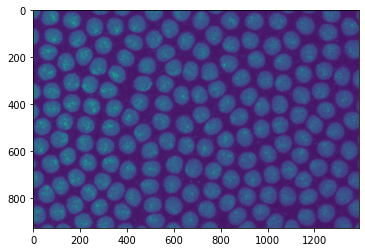

In [33]:
# Using the same array we read in, only difference is we specify the other channel
zstack = array1[1, 1, :, ...] #(timepoint, channel, etc.) this one is timepoint 1
zstack.shape

zstack_MAX= np.max(zstack, axis=0)
plt.imshow(zstack_MAX)
plt.show()

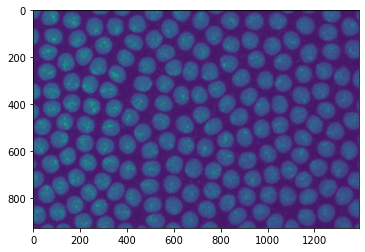

In [34]:
# Convert to 8bit
zstack_MAX_8bit = img_as_ubyte(zstack_MAX)

# Check it out
plt.figure()
plt.imshow(zstack_MAX_8bit);

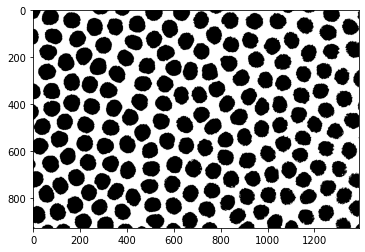

In [36]:
#### PART 1: Find centers with a conservative threshold
### First perform the conservative threshold on every point in the Z axis 
### with the Otsu threshold blur image and remove noise

zstack_MAX_8bit_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 1)

otsuthresh = filters.threshold_otsu(zstack_MAX_8bit_GausFilt) # grey scale 
zstack_MAX_8bit_GausFilt_localtheshold = zstack_MAX_8bit_GausFilt > otsuthresh

plt.figure()
plt.imshow(zstack_MAX_8bit_GausFilt_localtheshold, cmap = "Greys");

### Calling the Centers

- [Euclidean distance transform](https://medium.com/on-coding/euclidean-distance-transform-d37e06958216).

Here we are reducing the image to a point where there is no noise connecting the nuclei enought to seperate them, but not too much so that we loose signal.

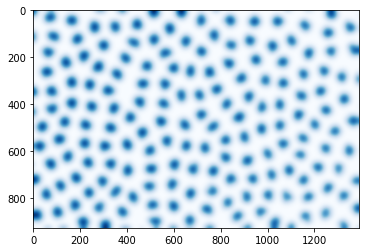

In [37]:
#### Then Call centers 
### Distance transform
distancetransform_combined_final = ndi.distance_transform_edt(zstack_MAX_8bit_GausFilt_localtheshold)

#### smoothen the distance transform
distancetransform_combined_final_gaus = ndi.filters.gaussian_filter(distancetransform_combined_final, 10)

## Check it out!
plt.figure()
plt.imshow(distancetransform_combined_final_gaus, cmap = "Blues");

In [38]:
#### Retrieve the local maxima from the distance transform
## Gives a true false for every pixel if it is the max local peak
Local_max = feature.peak_local_max(distancetransform_combined_final_gaus, indices = False, min_distance = 40)
Local_max_bigger = ndi.filters.maximum_filter(Local_max, size=20)


---

## Assigning a unique ID to each Nuclei over time

Below is a bit of an exploration into what works better for achieving this. We choose to use the centers for this.

In [39]:
# makes a mask so that I can visualize on top of the original image
Local_max_mask = np.ma.array(Local_max_bigger, mask=Local_max_bigger==0)

#Add that mask back into the watershed image
CenterPointArrays = Local_max_bigger

#### PART 2: Now make a mask with a permissive threshold that goes all the way to the 
##### edges of the nuclei.
image_GausFilt = ndi.filters.gaussian_filter(zstack_MAX_8bit, 20)
localthresh = filters.threshold_local(image_GausFilt, 41)
image_GausFilt_localtheshold = image_GausFilt > localthresh
image_GausFilt_localtheshold_dilate = morphology.binary_dilation(image_GausFilt_localtheshold)
EdgeMask = image_GausFilt_localtheshold_dilate

#### Part 3: watershed
## Seperate objects
CenterPointArrays_items, num = ndi.label(CenterPointArrays)

## Watershed
watershed_image = morphology.watershed(~zstack_MAX_8bit_GausFilt, CenterPointArrays_items, mask = EdgeMask)

#### Part 4: Clear borders
Watershed_ClearBorders = segmentation.clear_border(watershed_image)

### Itemize
labeled_array_segmentation, num_features_seg = ndi.label(Local_max_mask)

## Don't understand how the CenterPointArrays is actually specifying points,
## We need to figure this out so I can assign nuclei identities
## - [ ] How do we give the area an identity?


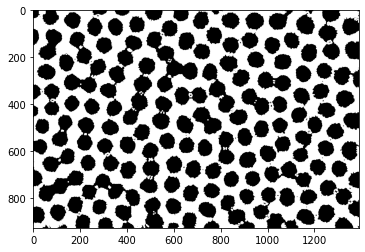

In [40]:
## Type 1: Edgemask
## EdgeMask Gaussian septerated. 
## Why not just do this instead of watershed?
EdgeMask_gauss = ndi.filters.gaussian_filter(EdgeMask, .5)
plt.figure()
plt.imshow(EdgeMask_gauss, "Greys");

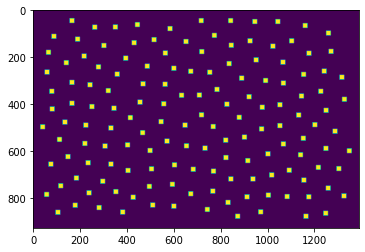

In [41]:
## Type 2 Local Max
## Notice we are loosing the outer nuclei, 
## We may need to fix later

plt.imshow(Local_max_bigger); #located the centers

In [42]:
EdgeMask_gauss #could prob turn into 1's and 0's and gather info from there

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [43]:
EdgeMask_binary = EdgeMask_gauss * 1 #turned into 1's and 0's 
EdgeMask_binary

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

Clustering the centers

As such, I also looked into gathering the coordinates for every single center and clustering these centers using the same DBSCAN algorithm above. The results were pretty good, and we did determine that the array1 image we were using had about 148 centers (excluding any cut off center/nucleuses on the edges of the original image)


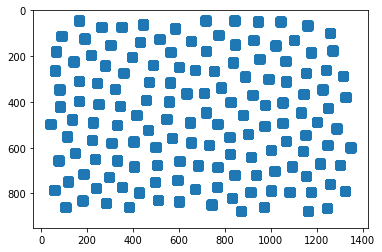

In [44]:
#get center coordinates (each center is equal to 1), 
#and the coordinates are the indices for row and column of the 1 value in matrix

y_len = len(Local_max_bigger)
x_len = len(Local_max_bigger[1])
centersX = []
centersY = []
for j in range(y_len): 
    for i in range(x_len):
        if Local_max_bigger[j][i] > 0: 
            centersX.append(i)
            centersY.append(j)

## Make Dataframe and visualize
centers = pd.DataFrame({"x":centersX, 
                        "y": centersY})
# plt.imshow(EdgeMask_gauss, "Greys");
plt.scatter(centers["x"], centers["y"])
plt.ylim([950, 0]);

In [45]:
cluster_ft = DBSCAN(eps=1, min_samples=4) 
labels = cluster_ft.fit_predict(centers)
labels #

array([  0,   0,   0, ..., 147, 147, 147])

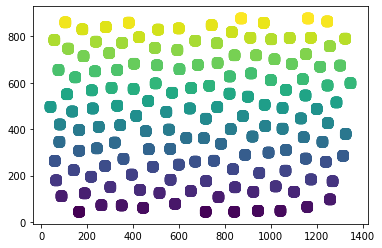

In [46]:
plt.figure()
plt.scatter(centers["x"], centers["y"], c=cluster_ft.labels_);
#it's hard to tell that they are different, but the colors 
#are different shades (otherwise it would look like above)
#indicating different clusters = 147 total unique ones 

In [47]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147])

In [48]:
centers["center_labels"] = labels

In [49]:
centers.head()

,x,y,center_labels
0,156,35,0
1,157,35,0
2,158,35,0
3,159,35,0
4,160,35,0


## Part 3: Associate spots with nuclei 


**1. Spectral Clustering (removed from this tutorial)**: We also looked into how I could cluster the nucleuses. Using the same/similar method above, we extracted all the coordinates/pixels that made up a nucleus (see below). we also tried clustering these points, but it was difficult to do because of overlaps. However, we did come across a method called Spectral Clustering: https://scikit-learn.org/stable/auto_examples/cluster/plot_segmentation_toy.html (will be very useful for separating blobs between each other and not between background), but we don't have the necessary computing power for it to run on the entire image. See We've sampled this method on a section of the image array and it seems to do pretty well in separating overlaps.

**2. Using Nuclei Centers**: See below


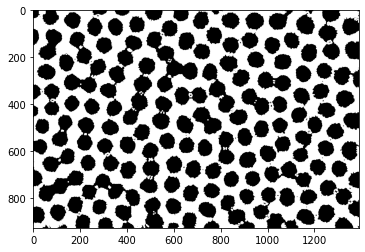

In [50]:
plt.imshow(EdgeMask_gauss, "Greys");

In [51]:
y_len = len(EdgeMask_gauss)
x_len = len(EdgeMask_gauss[1])
nucX = []
nucY = []
for j in range(y_len): 
    for i in range(x_len):
        if EdgeMask_gauss[j][i] > 0: 
            nucX.append(i)
            nucY.append(j)
      

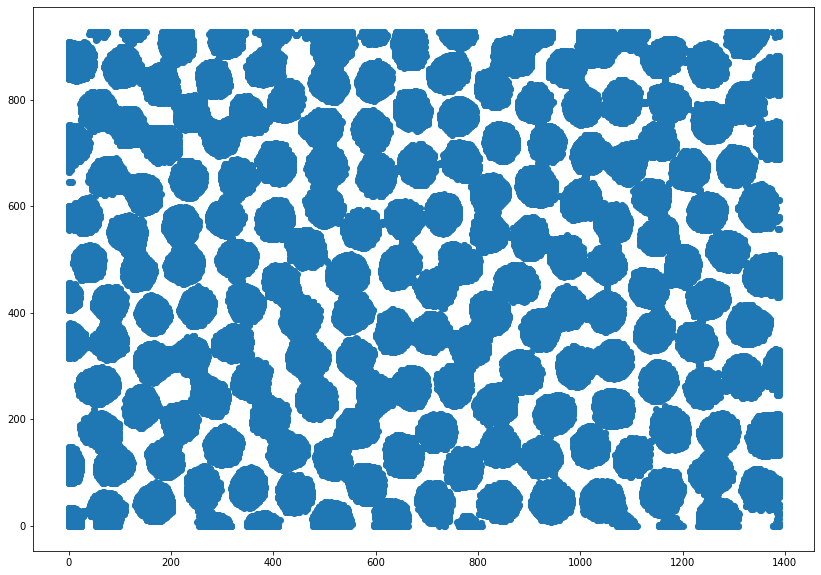

In [52]:
nuc = pd.DataFrame({"x":nucX, 
                    "y": nucY})
# plt.imshow(EdgeMask_gauss, "Greys");
plt.figure(figsize=(14, 10))
plt.scatter(nuc["x"], nuc["y"]);
# plt.ylim([950, 0]);
# plt.axis((0, 310, 200, 0)); #notice that centers are all squares

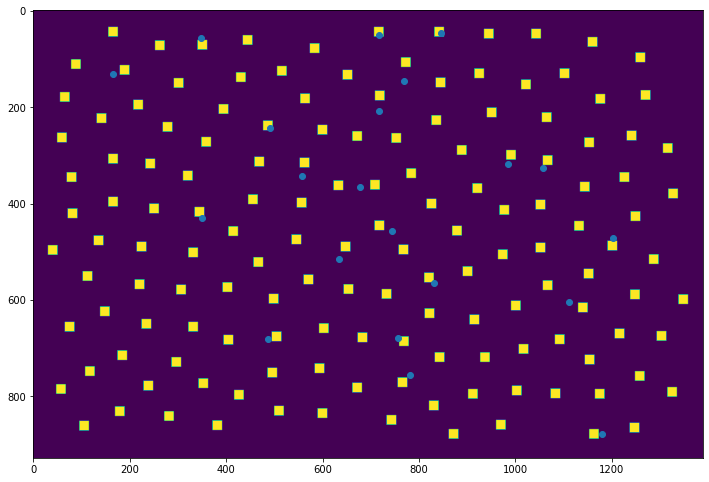

In [53]:
timepoint1 = trial1[trial1["timept"] == 1] #test with these since above is only for 1 timepoint of array1

plt.figure(figsize=(12, 10))
plt.imshow(Local_max_bigger) #centers
# plt.imshow(EdgeMask_gauss) #nucleus 
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)

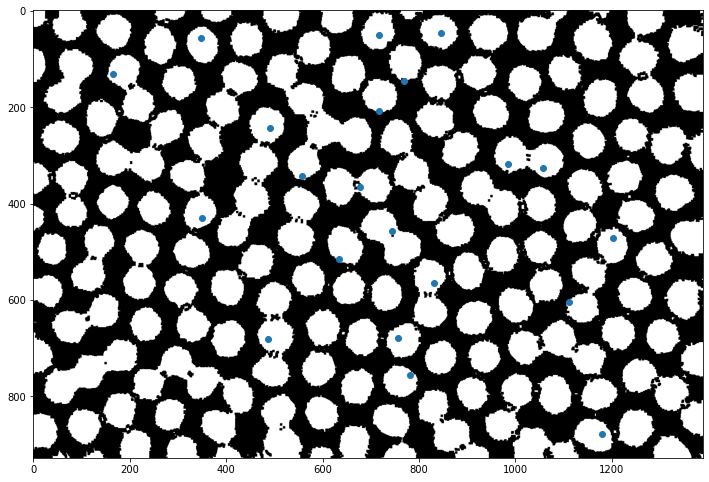

In [54]:
## Double check with real image
plt.figure(figsize=(12, 10))
plt.imshow(EdgeMask_gauss, cmap="gray") #nucleus 
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)

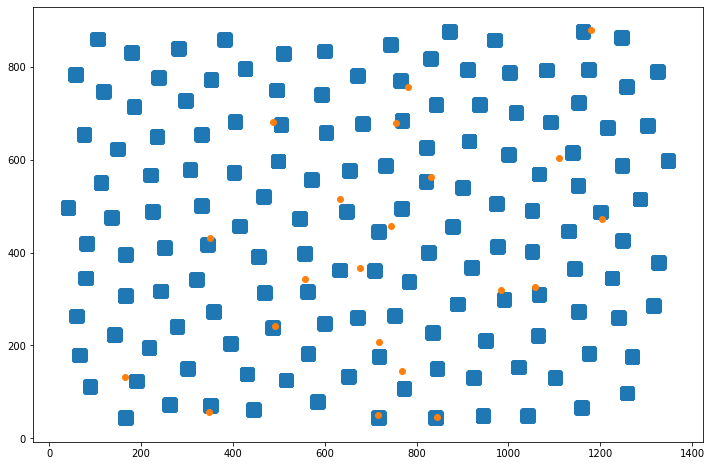

In [55]:
timepoint1 = trial1[trial1["timept"] == 1] #test with 1 timepoint of array1

plt.figure(figsize=(12, 8))
plt.scatter(centers["x"], centers["y"]); #centers plot (with the pixel centers from df)
plt.scatter(timepoint1["x"], timepoint1["y"]); #points (for timepoint1)

Let's try associating the MS2 spots with the centers of the nucleus

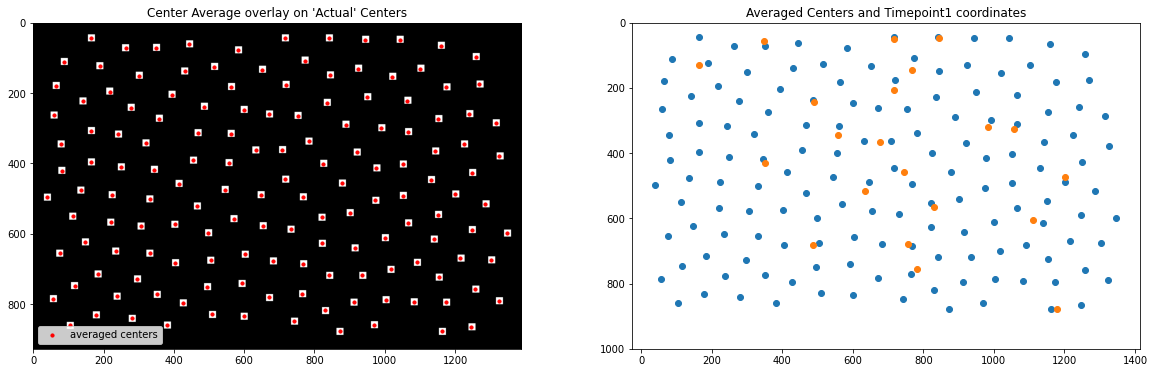

In [56]:
avg_cent = centers.groupby("center_labels").mean() #average of the centers (so that it's only one coordinate)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].imshow(Local_max_bigger, cmap="gray", label="actual") #actual centers
ax[0].scatter(avg_cent.x, avg_cent.y, s=10, color='red', label="averaged centers"); #averaged centers coords
ax[0].set_title("Center Average overlay on 'Actual' Centers")
ax[0].legend()

ax[1].scatter(avg_cent.x, avg_cent.y);
ax[1].scatter(timepoint1["x"], timepoint1["y"]);
ax[1].set_ylim(1000, 0);
ax[1].set_title("Averaged Centers and Timepoint1 coordinates");

In [57]:
# let's loop through the timepoint 1 coordinates and compare it with all the avg_cent point coordinates, 
# if it's close then i'll associate that MS2 point to that center (and that MS2 spot will be grouped the same label as the centers)
# there's probably a clustering algorithm that optimizes this ... (kmeans on MS2 spots with fixed centers?)

#we're going to be using euclidean distance
def euclidean_dist(x1, y1, x2, y2): 
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

dist = float('inf') #temp
closest_center_label = -1 #temp
#in the same order as timepoint1 inputs
label_list = []

for i in range(len(timepoint1)): 
    x1 = timepoint1.iloc[i]["x"]
    y1 = timepoint1.iloc[i]["y"]
    
    for j in range(len(avg_cent)): 
        x2 = avg_cent.iloc[j]["x"]
        y2 = avg_cent.iloc[j]["y"]
        
        new_dist = euclidean_dist(x1, y1, x2, y2)
        if new_dist < dist: 
            dist = new_dist
            closest_center_label = avg_cent.index[j]
            
    #add/record in dictionary after searching through all centers
    label_list.append(closest_center_label)
    #reset distance 
    dist = float('inf')

In [58]:
timepoint1["closest_center_labels"] = label_list
timepoint1

/Users/cierapink/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,x,y,timept,DBSCAN_labels,closest_center_labels
20,1180.0,879.0,1.0,0,147
21,781.0,756.0,1.0,15,125
22,487.0,681.0,1.0,2,110
23,756.0,680.0,1.0,16,114
24,1111.0,604.0,1.0,17,100
25,831.0,564.0,1.0,-1,88
26,634.0,515.0,1.0,18,77
27,1203.0,472.0,1.0,-1,75
28,744.0,458.0,1.0,19,69
29,350.0,431.0,1.0,20,66


Now, let's plot and compare to make sure it looks okay.

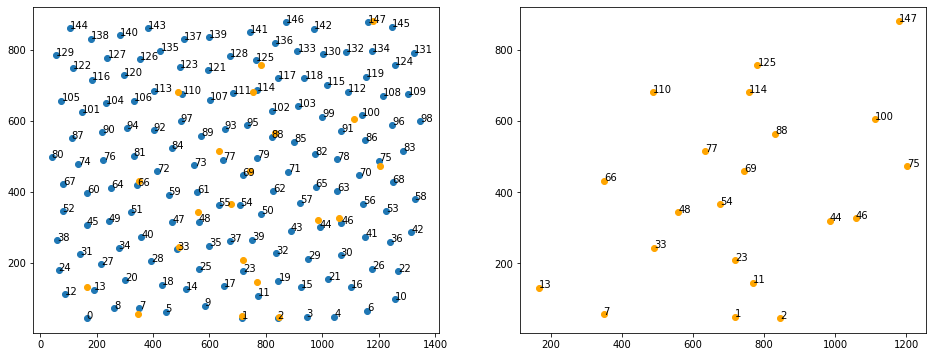

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(avg_cent.x, avg_cent.y);
ax[0].scatter(timepoint1["x"], timepoint1["y"], color="orange");
for i, txt in enumerate(np.arange(148)): #counter and text
    ax[0].annotate(txt, (avg_cent.iloc[i]["x"], avg_cent.iloc[i]["y"]))


ax[1].scatter(timepoint1["x"], timepoint1["y"], color="orange");
for i, txt in enumerate(timepoint1["closest_center_labels"]): #counter and text
    ax[1].annotate(txt, (timepoint1.iloc[i]["x"], timepoint1.iloc[i]["y"]))



Yay! Looks like it works pretty well, so let's abstract this to all the timepoints. First let's create a function to associate the center labels to the MS2 coordinate points.

**Now we ask the question about are so called "outliers". How do they fit in?**

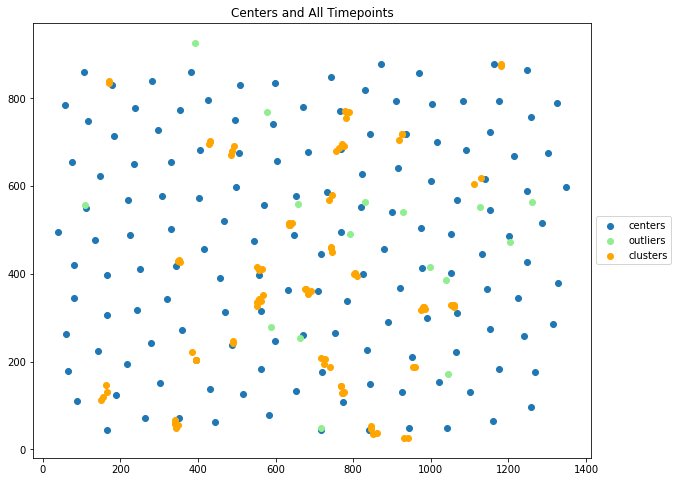

In [60]:
plt.figure(figsize=(10, 8))

plt.scatter(avg_cent.x, avg_cent.y, label="centers");
plt.scatter(trial1[trial1["DBSCAN_labels"] == -1]["x"], trial1[trial1["DBSCAN_labels"] == -1]["y"], color="lightgreen", label="outliers");
plt.scatter(trial1[trial1["DBSCAN_labels"] != -1]["x"], trial1[trial1["DBSCAN_labels"] != -1]["y"], color="orange", label="clusters");
plt.title("Centers and All Timepoints");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

#supposed outlier points are in lightgreen
#all other MS2 spots are in orange
#center of nuclei are in blue

#but it does seem like there are some light green points near centers 
#not sure if this means that some of our clusterings for -1 are not actually noise

## Part 4: Creating the data structure to put all the information together

Now we have gotten through our workflow as shitty as possible, so let's put everything together into a data structure where we can tell if an MS2 spot is turning on and off.



In [ ]:
#function
def associate_centers(df):
    
    dist = float('inf') #temp
    closest_center_label = -1 #temp
    #in the same order as trial1 inputs
    label_list = []

    for i in range(len(df)): 
        x1 = df.iloc[i]["x"]
        y1 = df.iloc[i]["y"]

        for j in range(len(avg_cent)): 
            x2 = avg_cent.iloc[j]["x"]
            y2 = avg_cent.iloc[j]["y"]

            new_dist = euclidean_dist(x1, y1, x2, y2)
            if new_dist < dist: 
                dist = new_dist
                closest_center_label = avg_cent.index[j]

        #add/record in dictionary after searching through all centers
        label_list.append(closest_center_label)
        #reset distance 
        dist = float('inf')
        
    return label_list

In [ ]:
label_list = associate_centers(trial1)
trial1["closest_center_labels"] = label_list

In [ ]:
trial1.groupby("DBSCAN_labels").agg(list)

# if we look at the "closest_center_labesl", notice that 
# the closest centers for the DBSCAN_label clusters are all the same
# which is great

In [ ]:
non_outliers = trial1[trial1["DBSCAN_labels"] != -1]
outliers = trial1[trial1["DBSCAN_labels"] == -1]

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(avg_cent.x, avg_cent.y);
ax[0].scatter(non_outliers["x"], non_outliers["y"], color="orange");
ax[0].scatter(outliers["x"], outliers["y"], color="lightgreen");
for i, txt in enumerate(np.arange(148)): #counter and text
    ax[0].annotate(txt, (avg_cent.iloc[i]["x"], avg_cent.iloc[i]["y"]))

    
ax[1].scatter(non_outliers["x"], non_outliers["y"], color="orange");
seen = []
for i, txt in enumerate(non_outliers["closest_center_labels"]): #counter and text
    if txt not in seen:
        ax[1].annotate(txt, (non_outliers.iloc[i]["x"], non_outliers.iloc[i]["y"]))
        seen.append(txt)

ax[1].scatter(outliers["x"], outliers["y"], color="lightgreen");
seen2 = []
for i, txt in enumerate(outliers["closest_center_labels"]): #counter and text
    if txt not in seen2:
        ax[1].annotate(txt, (outliers.iloc[i]["x"], outliers.iloc[i]["y"]))
        seen2.append(txt)
        
ax[1].set_title("All Timepoints and Center Labels");

So from just looking at things, it seems to do pretty well.

Now, if we want to see if an MS2 spot is "on" or "off", we can simply groupby and timepoints and look for whether a certain DBSCAN_label is in that group or not at that timepoint.

In [ ]:
trial1.groupby("DBSCAN_labels").agg(list)[1:6]

# note: I might average the MS2 spot points (after grouping to get a standard coordinate for that MS2 dot)
# may also average the closest_center_labels --
# this will help me classify a MS2 spot to one center label 
# (if for some reason a cluster has different cluster labels, we will go with the majority)

# Conclusion

So by the end of this, we have a couple of things accomplished: 

- We have the coordinates of the MS2 spots for all timepoints
- We have the group labels of the MS2 spots for all timepoints
- We have the coordinats of all the pixels that make up all the centers
- We have the coordinates of all the pixels that make up the nucleus

Our next steps: 

- Figure out how to associate the MS2 spots with the nucleus and/or centers
- Combine the dataframes and group the pixels that make up the nucleus/centers together
- Compute the clusters/cluster labels for the nucleuses

There's also a couple of things we need to go back and improve on once we get to the last stage of constructing a full dataframe/dataset: 

- Figure out how to automate the threshold value for clustering, blob detection, and other algorithms
- How to consolidate this entire process into one big function or method
- Construct better visualizations of this process